## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
# Dictionary to store mtx and dist parameter from all calibration.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
dist_pickle = {} # # Save the camera calibration result for later use.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite('../camera_cal/undist' + str(index) + '.jpg',dst)
        
        # Save the camera calibration result for later use
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.imshow('dst',dst)
        #cv2.waitKey(500)
        
    else:
        print("False is", fname)

cv2.destroyAllWindows()
pickle.dump( dist_pickle, open( "../camera_cal/dist_pickle.p", "wb" ) )

False is ../camera_cal\calibration1.jpg
False is ../camera_cal\calibration4.jpg
False is ../camera_cal\calibration5.jpg


## And so on and so forth...

552.908283811 m 533.919161996 m
Vehicle is 0.470061996351 m left from center


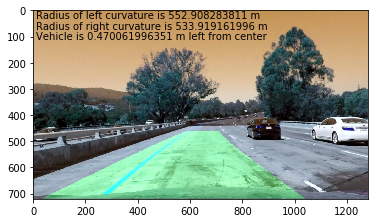

524.095244109 m 542.215287852 m
Vehicle is 0.467032146832 m left from center


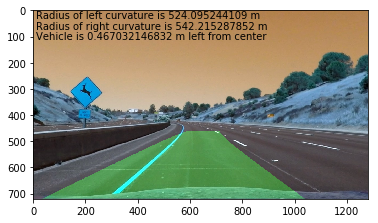

498.767672375 m 459.823328971 m
Vehicle is 0.454962220227 m left from center


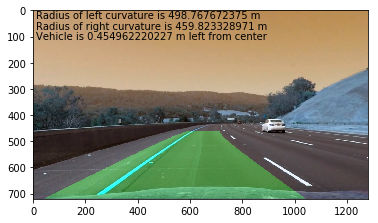

586.108167645 m 569.47447968 m
Vehicle is 0.475268635243 m left from center


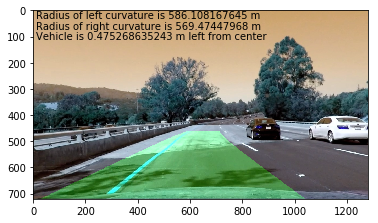

509.293764585 m 532.623509341 m
Vehicle is 0.473181016868 m left from center


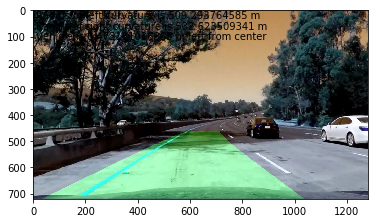

564.07630941 m 672.716771413 m
Vehicle is 0.48449755405 m left from center


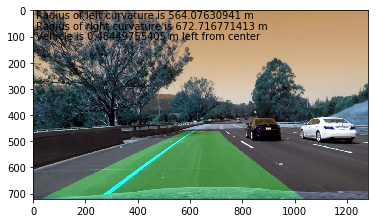

In [38]:
# Undistort driving images by the above result of camera calibration

pickle.load(open("../camera_cal/dist_pickle.p", "rb"))

# Difine the function for binalizing the images.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    #apply threshould
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    #Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scal_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    #Apply threshould
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_tjresh[1])] = 1
    return binary_output

def color_threshould(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[((s_binary == 1) & (v_binary == 1))] = 1
    return output

#def window_mask(width, height, imag_ref, center, level):
#    output = np.zeros_like(img_ref)
#    output[int(img_ref.shape[0])]
#    return output

# Make a list of calibration images
images = glob.glob('../test_images/test*.jpg')

for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # process image and generate binary pixel of interested
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255)) #12
    grady = abs_sobel_thresh(img, orient='y',  thresh=(25,255)) #25
    c_binary = color_threshould(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
    
    result = preprocessImage
    
    cv2.imwrite('../test_images/tracked' + str(index + 1) + '.jpg',result)
    
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    #perform the transform
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)

    #binary_warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    binary_warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Generate some fake data to represent lane-line pixels
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3
    #plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    #plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    #plt.plot(left_fitx, ploty, color='green', linewidth=3)
    #plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    #Vehicle center
    camera_position = img.shape[1]/2
    
    lane_center = (right_fitx[719] + left_fitx[719])/2
    
    center_offset_pixels = abs(camera_position - lane_center)*xm_per_pix
    
    if camera_position - lane_center > 0:
        print("Vehicle is " + str(center_offset_pixels) + " m left from center" )
    if camera_position - lane_center < 0:
        print("Vehicle is " + str(center_offset_pixels) + " m  from right center" )
    
    result = binary_warped
    
    cv2.imwrite('../test_images/transform' + str(index + 1) + '.jpg',result)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result_2 = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    plt.imshow(result_2)
    plt.text(10,30, "Radius of left curvature is " + str(left_curverad) + " m")
    plt.text(10,70, "Radius of right curvature is " + str(right_curverad) + " m")
    if camera_position - lane_center > 0:
        plt.text(10, 110, "Vehicle is " + str(center_offset_pixels) + " m left from center" )
    if camera_position - lane_center < 0:
        plt.text(10, 110, "Vehicle is " + str(center_offset_pixels) + " m  from right center" )
    plt.show()

In [39]:
# Pipe line of preprocess and lane line detection
def pipeline(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # process image and generate binary pixel of interested
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255)) #12
    grady = abs_sobel_thresh(img, orient='y',  thresh=(25,255)) #25
    c_binary = color_threshould(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
        
    src = np.float32(
    [[(img_size[0] / 2) - 80, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 80), img_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    #perform the transform
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)
    
    binary_warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Pull out the x and y sizes and make a copy of the image
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    # Define a triangle region of interest 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing
    # Note: if you run this code, you'll find these are not sensible values!!
    # But you'll get a chance to play with them soon in a quiz 
    left_bottom = [450, 720]
    right_bottom = [850, 720]
    apex = [650, 200]

    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = ((YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])))|\
                    (XX < 100) |\
                    (XX > 1180)
    
    binary_warped[region_thresholds] = 0
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Vehicle center
    camera_position = img.shape[1]/2
    
    lane_center = (right_fitx[719] + left_fitx[719])/2
    
    center_offset_pixels = abs(camera_position - lane_center)*xm_per_pix
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, "Radius of left curvature is " + str(left_curverad) + " m", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    cv2.putText(result, "Radius of right curvature is " + str(right_curverad) + " m", (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    if camera_position - lane_center >= 0:
        cv2.putText(result, "Vehicle is " + str(center_offset_pixels) + " m right from center", (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    if camera_position - lane_center < 0:
        cv2.putText(result, "Vehicle is " + str(center_offset_pixels) + " m  left from center", (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    return result

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

project_output = '../project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("../project_video.mp4").subclip(0, 50)
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ../project_output.mp4
[MoviePy] Writing video ../project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1250/1251 [04:55<00:00,  2.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_output.mp4 

Wall time: 5min 18s


611.998640649 m 526.644801671 m


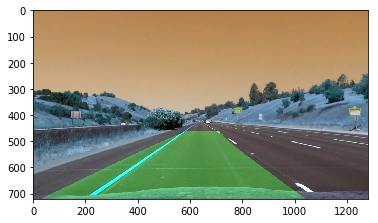

In [3]:
# Undistort driving images by the above result of camera calibration

pickle.load(open("../camera_cal/dist_pickle.p", "rb"))

# Difine the function for binalizing the images.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    #apply threshould
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    #Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scal_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    #Apply threshould
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_tjresh[1])] = 1
    return binary_output

def color_threshould(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] == 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] == 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] == 1
    return output

#def window_mask(width, height, imag_ref, center, level):
#    output = np.zeros_like(img_ref)
#    output[int(img_ref.shape[0])]
#    return output

# Make a list of calibration images
images = glob.glob('../test_images/straight_lines1.jpg')

for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # process image and generate binary pixel of interested
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255)) #12
    grady = abs_sobel_thresh(img, orient='y',  thresh=(25,255)) #25
    c_binary = color_threshould(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
    
    result = preprocessImage
    
    cv2.imwrite('../test_images/tracked' + str(index + 1) + '.jpg',result)
    
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    #perform the transform
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)

    #binary_warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    binary_warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Generate some fake data to represent lane-line pixels
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3
    #plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    #plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    #plt.plot(left_fitx, ploty, color='green', linewidth=3)
    #plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    result = binary_warped
    
    cv2.imwrite('../test_images/transform' + str(index + 1) + '.jpg',result)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result_2 = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    plt.imshow(result_2)
    plt.show()